In [1]:
import numpy as np

# The Minesweeper class contains the solution board, the current board, and allows you to select grids from the board in order to play.
class MineSweeper:
    def __init__(self, height, width, mines):
        self.height = height
        self.width = width
        self.mines = mines
        self.firstSelect = True
        self.board = np.full((height, width), -1.0)
    def isMine(self, x, y):
        # In classic minesweeper, the first grid you select will always be free and not be surrounded by any mines.
        # The easiest option is to just create new boards until that is the case.
        isMine = True
        if self.firstSelect == True:
            self.firstSelect = False
            isMine = False
            self.solutionBoard = np.ones((self.height, self.width))
            indices = np.random.choice(self.height*self.width, replace=False, size=int(self.mines))
            self.solutionBoard[np.unravel_index(indices, self.solutionBoard.shape)] = 0
            numMines = 0
            for j in range(np.maximum(y-1,0), np.minimum(y+2,self.height)):
                for i in range(np.maximum(x-1,0), np.minimum(x+2,self.width)):
                    if self.solutionBoard[j][i] == 0:
                        numMines += 1

            while self.solutionBoard[y][x] == 0 or numMines != 0:
                self.solutionBoard = np.ones((self.height, self.width))
                indices = np.random.choice(self.height*self.width, replace=False, size=int(self.mines))
                self.solutionBoard[np.unravel_index(indices, self.solutionBoard.shape)] = 0
                numMines = 0
                for j in range(np.maximum(y-1,0), np.minimum(y+2,self.height)):
                    for i in range(np.maximum(x-1,0), np.minimum(x+2,self.width)):
                        if self.solutionBoard[j][i] == 0:
                            numMines += 1
            self.allowedChoices = self.solutionBoard.copy()
            self.board[y][x] = numMines
        elif (self.board[y][x] >= 0):
            isMine = True
        # Use solution board to check number of mines around selected grid.
        elif self.solutionBoard[y][x] == 1:
            isMine = False
            numMines = 0
            for j in range(np.maximum(y-1,0), np.minimum(y+2,self.height)):
                for i in range(np.maximum(x-1,0), np.minimum(x+2,self.width)):
                    if self.solutionBoard[j][i] == 0:
                        numMines += 1
            self.board[y][x] = numMines
        return isMine
    def updateChoices(self, x, y):
        self.allowedChoices[y][x] = 0
    def resetBoard(self):
        self.board = np.full((self.height, self.width), -1.0)
        self.allowedChoices = self.solutionBoard.copy()

In [11]:
# Unorthodox network treats minesweeper as a binary classification problem where grids can be
# classified as either mines or spaces, as opposed to reinforcement learning.

import tensorflow as tf
tf.keras.backend.set_floatx('float32')

# Set configuration of minesweeper board.
height, width, mines = (4,4,2)
inputs = tf.keras.Input(shape=(height,width,1))
x1 = tf.keras.layers.Conv2D(filters=100, kernel_size=4, activation='relu', padding="SAME")(inputs)
x2 = tf.keras.layers.Flatten()(x1)
outputs = tf.keras.layers.Dense(height*width, activation="softmax")(x2)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.3)

# Personalized loss function is similar to binary cross entropy but only does binary cross entropy on its
# most confident guess.
def minesweeper_loss(y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true)
    y_true = np.eye(len(y_true[0]))[np.where(y_true[0] == 1)]
    y_pred = tf.convert_to_tensor(y_pred)
    crossEntropy = y_true * tf.math.log(y_pred + tf.keras.backend.epsilon())
    crossEntropy += (1 - y_true) * tf.math.log(1 - y_pred + tf.keras.backend.epsilon())
    crossEntropy = -tf.math.reduce_mean(crossEntropy, axis=1)
    return tf.math.reduce_min(crossEntropy)

# Number of games played, batch size is number of moves made before performing gradient descent
games = 1001
batch_size = 4
loops = height*width-mines
losses = []
batches = np.full(loops//batch_size, batch_size)
if (loops%batch_size!=0):
    batches = np.append(batches, loops%batch_size)

for game in range(games):
    loss_value_cum = 0
    sweep = MineSweeper(height, width, mines)
    for i in range(len(batches)):
        loss_value = 0
        with tf.GradientTape() as tape:
            for j in range(batches[i]):  
                # input = [[[1, 0] if val == -1 else [0, val] for val in sweep.board[i]] for i in range(height)]
                input = np.reshape(sweep.board,(1,height,width,1))
                y_pred = model(input)
                
                # Board is not yet initialized until the first move is performed
                if not (i==0 and j==0):
                    y_true = np.reshape(sweep.allowedChoices, (1, height*width))
                    choosableGrids = np.reshape(sweep.allowedChoices + 1 - sweep.solutionBoard, (1, height*width))
                    y_pred = tf.math.multiply(choosableGrids, y_pred)
                    y_pred = y_pred * 1/(tf.math.reduce_sum(y_pred)+tf.keras.backend.epsilon())

                choices = tf.argsort(y_pred, direction='DESCENDING').numpy()[0]
                choiceNumber = 0
                while sweep.isMine(choices[choiceNumber]%width, choices[choiceNumber]//width):
                    choiceNumber += 1
                # [0][np.argmax(y_pred)]
                if i==0 and j==0:
                    y_true = np.reshape(sweep.allowedChoices, (1, height*width))
                    
                loss_value += minesweeper_loss(y_true, y_pred)
                sweep.updateChoices(choices[choiceNumber]%width, choices[choiceNumber]//width)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        loss_value_cum += loss_value
        loss_value = 0

    if game % 100 == 0:
        print("Game " + str(game) + " loss = " + str(loss_value_cum.numpy()))
    losses.append(loss_value_cum.numpy())

Game 0 loss = 2.6211016
Game 100 loss = 0.37397298
Game 200 loss = 0.20989516
Game 300 loss = 0.2735365
Game 400 loss = 0.100979954
Game 500 loss = 0.033549435
Game 600 loss = 0.05628314
Game 700 loss = 0.0076219896
Game 800 loss = 0.012043941
Game 900 loss = 0.00717872
Game 1000 loss = 0.0072487365


In [12]:
# Games are played using the finished model to determine the actual accuracy
games = 100
wins = 0
rightChoicesArray = []
for j in range(games):
    # sweep.resetBoard()
    rightChoices = [0]*(height*width-mines)
    sweep = MineSweeper(height, width, mines)
    win = True
    loss_value = 0
    for i in range(height*width-mines):
        # input = [[[1, 0] if val == -1 else [0, val] for val in sweep.board[i]] for i in range(height)]
        input = np.reshape(sweep.board,(1,height,width,1))
        y_pred = model(input)
        if i != 0:
            y_true = np.reshape(sweep.allowedChoices, (1, height*width))
            choosableGrids = np.reshape(sweep.allowedChoices + 1 - sweep.solutionBoard, (1, height*width))
            y_pred = tf.math.multiply(choosableGrids, y_pred)   
            y_pred = y_pred * 1/(tf.math.reduce_sum(y_pred)+tf.keras.backend.epsilon())

        choices = tf.argsort(y_pred, direction='DESCENDING').numpy()[0]
        choiceNumber = 0
        while sweep.isMine(choices[choiceNumber]%width, choices[choiceNumber]//width):
            choiceNumber += 1
        if choiceNumber != 0:
            rightChoices[i] = 1
            win = False
        # print(choiceNumber)
        # [0][np.argmax(y_pred)]
        if i == 0:
            y_true = np.reshape(sweep.allowedChoices, (1, height*width))
            choosableGrids = np.reshape(sweep.allowedChoices + 1 - sweep.solutionBoard, (1, height*width))

        # print(np.argmax(y_pred)%width, np.argmax(y_pred)//width)
        # print(np.reshape(y_pred, (height,width)))
        # print(np.reshape(sweep.allowedChoices, (height, width)))
        # print(minesweeper_loss(y_true, y_pred))
        # loss_value += minesweeper_loss(y_true, y_pred)
        sweep.updateChoices(choices[choiceNumber]%width, choices[choiceNumber]//width)
    if win == True:
        wins += 1
    rightChoicesArray.append(rightChoices)
    # print(loss_value)
    
print("Win accuracy: " + str(100 * wins/games) + "%")

Win accuracy: 100.0%


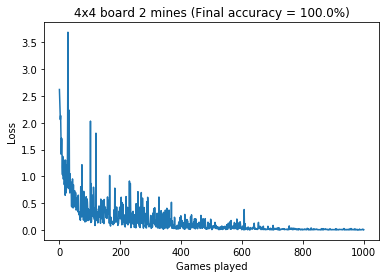

In [13]:
# Simple loss over time graph

import matplotlib.pyplot as plt
combine = 1
losses2 = [np.mean(losses[i*combine:(i+1)*combine]) for i in range(int(len(losses)/combine))]
plt.plot([i for i in range(int(len(losses)/combine))], losses2)
plt.xlabel("Games played")
plt.ylabel("Loss")
# plt.ylim((0,2))
plt.title(str(height) + "x" + str(width) + " board " + str(mines) + " mines (Final accuracy = " + str(100 * wins/games) + "%)")
plt.show()

# topGames = 0.9
# topGamesIndex = np.argpartition(np.sum(np.array(rightChoicesArray), axis=1), int(games*topGames))[:int(games*topGames)]

# def func(x):
#     return 10/(height*width-x)
# x = np.linspace(0,height*width-mines-1,height*width-mines-1)
# plt.plot([i for i in range(height*width-mines)], np.mean([rightChoicesArray[i] for i in topGamesIndex], axis=0))
# plt.plot(x, (1/((1/topGames)**(1/(height*width-mines))))*func(x))
# plt.xlabel("Game progression (Move number)")
# plt.ylabel("Probability of making a wrong move")
# plt.title("Performance analysis of model over top " + str(int(topGames*100)) + "% of games")
# plt.legend(['Wrong moves played', 'Wrong moves from random guessing'], loc="upper left")
# plt.show()